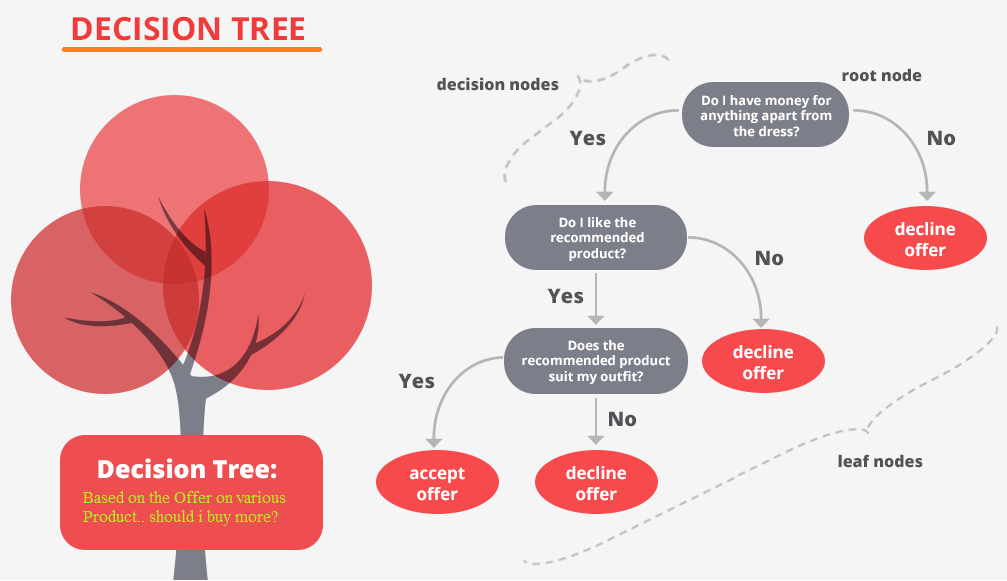

# Lab: Decision Trees

In [1]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import HTML
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
import graphviz 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf


## 8.3.1 Fitting Classification Trees
The `tree` library is used to construct classification and regression trees.

In [2]:
# from sklearn import tree

We first use classification trees to analyze the `Carseats` data set. In these data, `Sales` is a continuous variable, and so we begin by recoding it as a binary variable. We use the python's parenthetical expression to create a variable, called `High`, which takes on a value of `1` if the `Sales` variable exceeds `8`, and takes on a value of `0` otherwise.

In [3]:
#Read in data
carseats_df = pd.read_csv('Carseats.csv')

# Check for missing values
assert carseats_df.isnull().sum().sum() == 0

# Create binary variable High 1 if Sales > 8
carseats_df['High'] = (carseats_df['Sales'] > 8).astype(np.float64)

# Create index for training set
np.random.seed(1)
train = np.random.random(len(carseats_df)) > 0.7

# Take a look at what we've done
carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1.0
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1.0
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1.0
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,0.0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,0.0


We now use the `tree()` function to fit a classification tree in order to predict `High` using all variables but `Sales`. 

In [4]:
# Use all features excpet response features
# No intercept
f = 'High ~ 0 + ' + ' + '.join(carseats_df.columns.drop(['Sales', 'High']))
y, X = pt.dmatrices(f, carseats_df)
y = y.flatten()

# Fit Sklearns tree classifier
clf = tree.DecisionTreeClassifier(max_depth=4).fit(X, y)

The `list(enumerate(X.design_info.column_names))` function lists the variables that are used as internal nodes in the tree.

In [5]:
# Provide key for variables
list(enumerate(X.design_info.column_names))

[(0, 'ShelveLoc[Bad]'),
 (1, 'ShelveLoc[Good]'),
 (2, 'ShelveLoc[Medium]'),
 (3, 'Urban[T.Yes]'),
 (4, 'US[T.Yes]'),
 (5, 'CompPrice'),
 (6, 'Income'),
 (7, 'Advertising'),
 (8, 'Population'),
 (9, 'Price'),
 (10, 'Age'),
 (11, 'Education')]

The `score` command will diplay the (training) error rate.

In [6]:
# Classifier gets a good score on training set due to overfitting
clf.score(X, y)

0.84

In [7]:
# Here's the confusion matrix
pd.DataFrame(confusion_matrix(y, clf.predict(X)), columns = ["PredLow", "PredHigh"], index = ["ActualLow", "ActualHigh"])

,PredLow,PredHigh
ActualLow,220,16
ActualHigh,48,116


`Sklearn` doesn't expose the same stats as `R`'s summary such as number of leaves. Here is what is available.

In [8]:
help(tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

In [9]:
clf.tree_.node_count

29

In [10]:
clf.tree_.max_depth

4

One of the most attractive properties of trees is that they can be graphically displayed. We use the `graphviz()` function to display the tree structure. 

In [11]:
# Visualise the tree with GraphViz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X.design_info.column_names,  
                                class_names=['Low', 'High'],  
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

The most important indicator of `Sales` appears to be shelving location, since the first branch differentiates `Good` locations from `Bad` and `Medium` locations. We can also get the relative importance of each variable within the tree using the `feature_importances_` attribute.

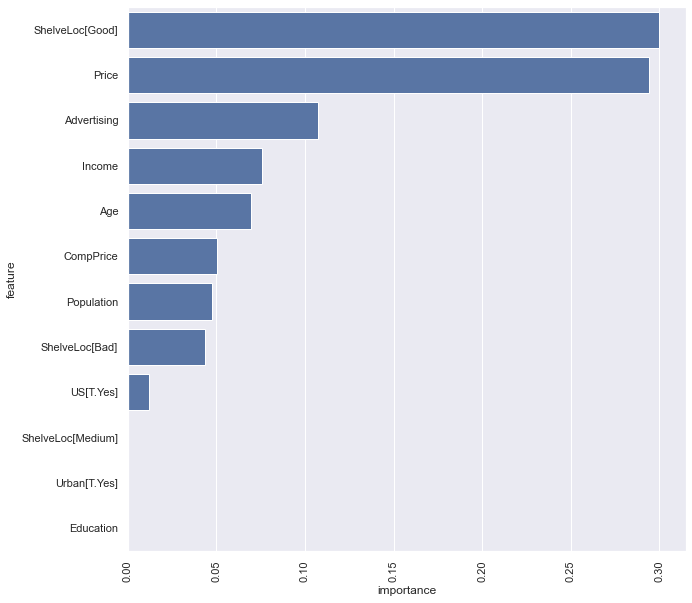

In [12]:
# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': clf.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

In order to properly evaluate the performance of a classification tree on these data, we must estimate the test error rather than simply computing the training error. We split the observations into a training set and a test set, build the tree using the training set, and evaluate its performance on the test data. The `predict() `function can be used for this purpose. 

In [13]:
# Fit Sklearn's tree classifier
clf = tree.DecisionTreeClassifier(max_depth=5).fit(X[train], y[train])

# Get confusion matrix for test set
y_hat = clf.predict(X[~train])
pd.DataFrame(confusion_matrix(y[~train], y_hat), columns = ["PredLow", "PredHigh"], index = ["ActualLow", "ActualHigh"])

,PredLow,PredHigh
ActualLow,139,28
ActualHigh,49,62


In [14]:
# Get proportion of correct classifications on test set
print('Test accuracy: {}'.format(np.around(clf.score(X[~train], y[~train]), 4)))

Test accuracy: 0.723


This approach leads to correct predictions for around 70% of the locations in the test data set. However, note variance in this result if above code snippet is run repeatedly. When you re-run the `predict()` function then you might get slightly different results, due to “ties”: for instance, this can happen when the training observations corresponding to a terminal node are evenly split between `1` and `0` response values.)

#### Pruning the tree
Next, we consider whether pruning the tree might lead to improved results. A for-loop performs cross-validation in order to determine the optimal level of tree complexity; cost complexity pruning is used in order to select a sequence of trees for consideration. 

Now, `Sklearn` doesn't support tree pruning at time of writing.

This is the closest I could find to an implementation: https://stackoverflow.com/questions/49428469/pruning-decision-trees

But the above is not pruning as described in ISLR, because in ISLR the tree is fit with a penalty function for the number of terminal nodes in the tree (see eq 8.4 p 309), whereas the above example is pruning based on some threshold for the 'value' variable, the meaning of which is unclear to me.

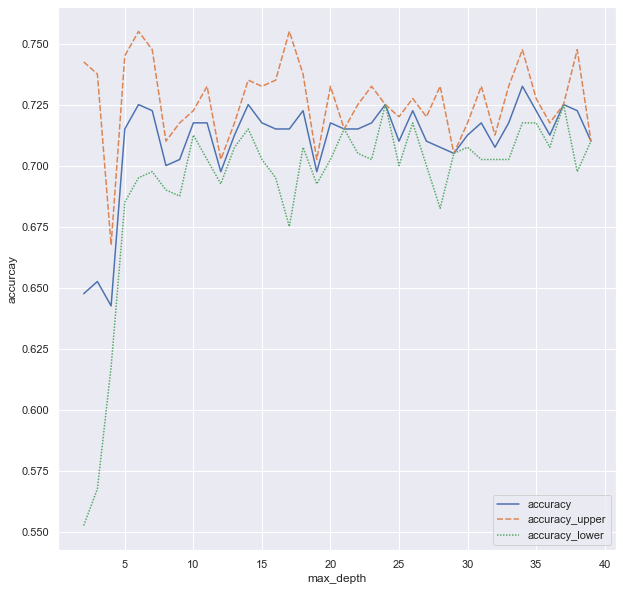

In [15]:
# How about using CV to compare trees with different number of leaf nodes 
# as defined by the max_depth parameter?

tuning_param = 'max_depth'
columns=[tuning_param, 'accuracy', 'accuracy_upper', 'accuracy_lower']

results = []
for m in np.arange(2, 40):
    clf = tree.DecisionTreeClassifier(max_depth=m)
    scores = cross_val_score(clf, X, y, cv=2)
    #rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(scores)
    conf_int = np.std(scores) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('accurcay');

Above we plot 2-fold cv test accuracy for increasing maximum depth of the tree confirms our original choice  of 5. The model appears to overfit only slightly as the number of leaves increases.

Note, and alternative approach is to increase `max_leaf_nodes` as a more coarse tuning parameter.

## Fitting Regression Trees

Here we fit a regression tree to the `Boston` data set. First, we create a training set, and fit the tree to the training data.

In [16]:
boston_df = datasets.load_boston() #Boston is part of SKLearn
boston_df = pd.DataFrame(data=np.c_[boston_df['data'], boston_df['target']], columns= [c for c in boston_df['feature_names']] + ['Price'])

np.random.seed(1)
train = np.random.rand(len(boston_df)) < 0.7

boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [17]:
f = 'Price ~ ' + ' + '.join(boston_df.columns.drop(['Price']))
y, X = pt.dmatrices(f, boston_df)

In [18]:
# Fit Sklearns tree classifier
clf = tree.DecisionTreeRegressor(max_leaf_nodes=5).fit(X[train], y[train])

y_hat = clf.predict(X[~train])
rmse = np.sqrt(metrics.mean_squared_error(y[~train], y_hat))
print('RMSE test: {}'.format(np.around(rmse, 3)))

RMSE test: 5.043


In [19]:
# Model accuracy score (like R^2)
clf.score(X[~train],y[~train])

0.7088400974174822

We now plot the tree.

In [20]:
# Visualise the tree with GraphViz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X.design_info.column_names, 
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

Notice that the output of indicates that only three of the variables have been used in constructing the tree.

The variable `lstat` measures the percentage of individuals with lower socioeconomic status, while the variable `rm` corresponds to the average number of rooms. The tree indicates that larger values of `rm`, or lower values of `lstat`, correspond to more expensive houses. For example, the tree predicts a median house price of $45,800 for homes in census tracts in which `rm` >= 7.437.

Now we use the loop function from above to see whether pruning the tree will improve performance.

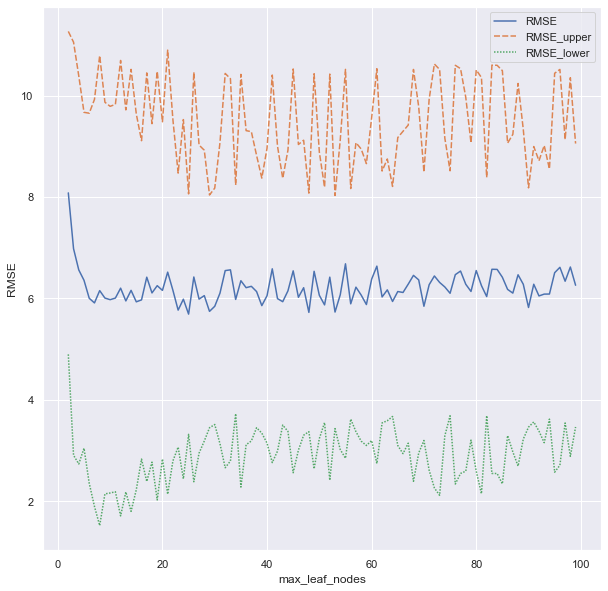

,RMSE,RMSE_upper,RMSE_lower
max_leaf_nodes,,,
25.0,5.691279,8.061396,3.321161


In [21]:
tuning_param = 'max_leaf_nodes'
cv_folds = 5
columns=[tuning_param, 'RMSE', 'RMSE_upper', 'RMSE_lower']

results = []
for m in np.arange(2, 100):
    reg = tree.DecisionTreeRegressor(max_leaf_nodes=m)
    scores = cross_val_score(reg, X[train], y[train], cv=cv_folds, scoring='neg_mean_squared_error')
    rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(rmses)
    conf_int = np.std(rmses) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('RMSE')
plt.show();

# Choose model
choice = plot_df[plot_df['RMSE'] == plot_df['RMSE'].min()]
display(choice)

In [22]:
reg = tree.DecisionTreeRegressor(max_leaf_nodes=np.int(choice.index[0])).fit(X[train], y[train])
y_hat = reg.predict(X[~train])

rmse = np.sqrt(metrics.mean_squared_error(y[~train], y_hat))
print('RMSE test: {}'.format(np.around(rmse, 3)))

RMSE test: 3.67


In [23]:
boston_df['Price'].median()*1000

21200.0

A test RMSE of 3.632 is achieved for the selected model, which suggest that this model can predict house prices to within \\$3,632 of the true median value of a house (\\$21,200 in this dataset)

## Bagging and Random Forests

Here we apply bagging and random forests to the Boston data, using the `RandomForestRegressor` package in `SKlearn`. The exact results obtained in this section may depend on the version of R and the version of the `RandomForestRegressor` package installed on your computer. Recall that bagging is simply a special case of a random forest with $m = p$. Therefore, the `RandomForestRegressor` function can be used to perform both random forests and bagging. We perform bagging as follows:

In [24]:
# Bagging with 100 trees
# although I'm using RandomForestRegressor algo here this is Bagging because max_features = n_predictors

max_features = X.shape[1]
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 8.879
RMSE test: 2.98


The argument `max_features = X.shape[1]` indicates that all 12 predictors should be considered for each split of the tree—in other words, that bagging should be done.

How well does this bagged model perform on the test set? Bagging seems to yield a significant improvement in RMSE for the test set of 2.98(compared to 3.632 for single optimal decision tree).

The test set MSE associated with the bagged regression tree is 11.135, about two-thirds of that obtained using an optimally-pruned single tree. We could change the number of trees grown by `RandomForestRegressor` using the `n_estimators` argument:

In [25]:
# Random Forest with 100 trees and 4 features considered at each split

max_features = 4
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 7.3
RMSE test: 2.702


Growing a random forest proceeds in exactly the same way, except that we use a smaller value of the mtry argument. By default, `RandomForestRegressor` uses $\frac{p}{3}$ variables when building a random forest of regression trees, and $\sqrt{p}$ variables when building a random forest of classification trees. Here we use `n_estimators` = 4.

Random forest yields a further improvement over bagging with RMSE of 2.702 with 4 features considered at each split.

Using the `feature_importances_` function, we can view the importance of each variable.

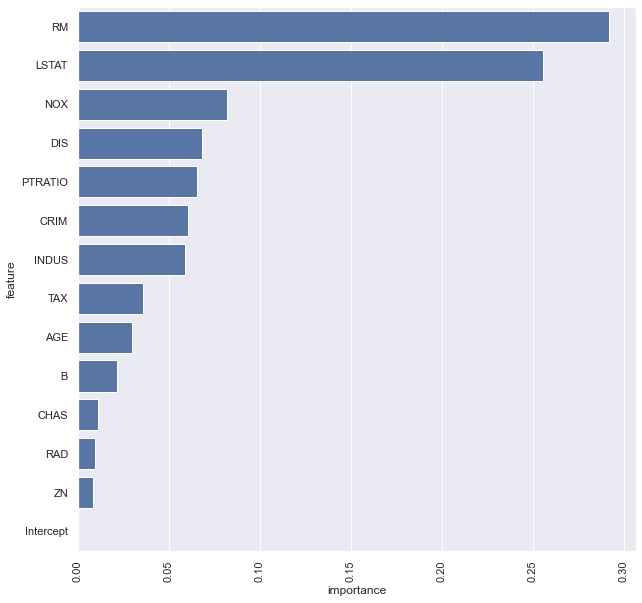

In [26]:
# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

The results indicate that across all of the trees considered in the random forest, the house size (rm) and the wealth of the community (lstat) are by far the two most important variables.

## Boosting

Here we use the `GradientBoostingRegressor` package, and within it the `SKLearn`, to fit boosted regression trees to the `Boston` data set. The argument `n_estimators = 5000` indicates that we want 5000  trees, and the option `max_depth = 4` limits the depth of each tree.

In [27]:
# Gradient boosting

max_features = 'auto'
l            = 0.1
tree_count   = 100
max_depth = 4

regr   = GradientBoostingRegressor(max_features=max_features, 
                                   random_state=1, 
                                   n_estimators=tree_count,
                                   learning_rate=l,
                                   max_depth=max_depth)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 8.221
RMSE test: 2.867


In [28]:
# Gradient boosting

max_features  = 4
learning_rate = 0.1
tree_count    = 100
max_depth = 4

regr   = GradientBoostingRegressor(max_features=max_features, 
                                   random_state=1, 
                                   n_estimators=tree_count,
                                   learning_rate=learning_rate,
                                   max_depth = 4)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 6.924
RMSE test: 2.631


With `max_features` set to `auto` all features are used, I assume we describe this as 'bagging with boosting'. This yields an RMSE of 2.867 a slight improvement over bagging 2.98.

Setting `max_features` to 4 gives the best RMSE so far at 2.631 which is almost half the error observed for a single tree regression.

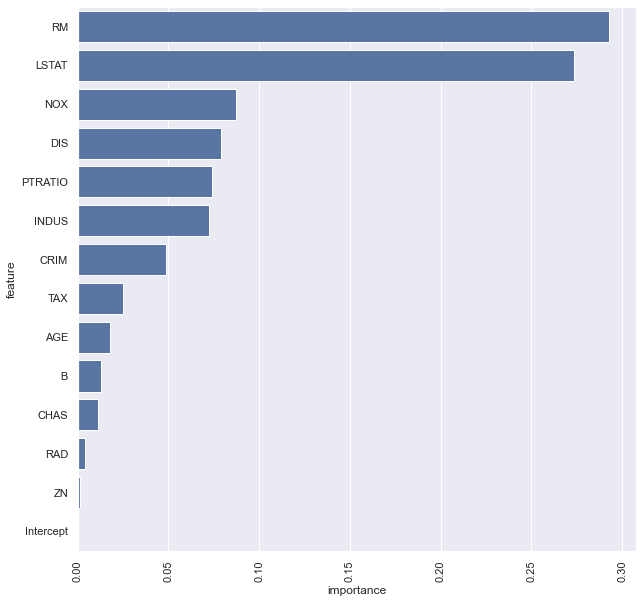

In [29]:
# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);